<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/Using_GAN_TO_find_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 73.2 MB/s eta 0:00:00


Importing necessary library

In [ ]:
import re
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import load
from matplotlib import pyplot
from scipy.ndimage import rotate
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import UpSampling3D
from scipy.ndimage import zoom
from random import randint
# Rest of your code


In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.models import Model




Origial code link --> https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

Comment about the code -> Goal of the code is to generate a image with all the part of the brain lebeled

We have used a Pix2Pix GAN network where we have taken a source image and a target image

source image link -> https://neurovault.org/images/1707/

target image is in google drive

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input((image_shape, image_shape, image_shape,3))
	# target image input
	in_target_image = Input((image_shape, image_shape, image_shape,3))
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv3D(32, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv3D(256, (4,4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile mode
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

#input_shape = 128
#opt = Adam(lr=0.0002, beta_1=0.5)
#model = define_discriminator(input_shape)
#model.output_shape
#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

In [ ]:
TRAIN_images = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/images_structural" +'/'
image2 = r"/content/drive/MyDrive/Harvard-Oxford cortical and subcortical structural atlases/HarvardOxford-sub-maxprob-thr25-2mm.nii"
MASK = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files/automated_segm"+'/'

Extracting the path of each images usnig the source path

In [ ]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_data_ids = [f.path for f in os.scandir(TRAIN_images)]

In [ ]:
train_data_mask_ids = [f.path for f in os.scandir(MASK)]

Extracting the IDs of each images usnig the images path and finding the image ids without mask and remove those ids that don't have mask  

In [ ]:
train_data_mask_ids.sort()
train_data_ids.sort()
mask_ids = []
for i in range(len(train_data_mask_ids)):
  test = train_data_mask_ids[i].split('_automated_approx_segm.nii')[0]
  test1 = test.split('/automated_segm/')[1]
  mask_ids.append(test1)

train_ids = []
for i in range(len(train_data_ids)):
  x = train_data_ids[i].split("/images_structural/")[1]
  train_ids.append(x)

result = []
for i in train_ids:
    if i not in mask_ids:
      result.append(i)

In [ ]:
len(result)

60

In [ ]:
for i in result:
  train_ids.remove(i)

In [ ]:
len(train_ids)

611

In [ ]:
train_ids.sort()

add a fake rgb channel to the image

In [ ]:
case_path = os.path.join(TRAIN_images, train_ids[0] )
data_path = os.path.join(case_path, f'{train_ids[0]}_FLAIR.nii')
#img2 = nib.load(path2).get_fdata()
img = nib.load(data_path).get_fdata()
rgb1 = np.stack([img] * 3, axis=-1)
rgb1.shape

(240, 240, 155, 3)

Loading the images with a target size of 128x128x128x3

In [ ]:
def load_images(path1,path2):
  src_list, tar_list = list(), list()
 # enumerate filenames in directory, assume all are images
  for i in range(0,100):
    case_path = os.path.join(path1, train_ids[i] )
    data_path = os.path.join(case_path, f'{train_ids[i]}_FLAIR.nii')
    img2 = nib.load(path2).get_fdata()
    img = nib.load(data_path).get_fdata()
    target_size= (91,109,91)
    flair_resize = ndimage.zoom(img, (target_size[0] / img.shape[0], target_size[1] / img.shape[1], target_size[2] / img.shape[2]), order=1)
    img2_resize = ndimage.zoom(img2, (target_size[0] / img2.shape[0], target_size[1] / img2.shape[1], target_size[2] / img2.shape[2]), order=1)
    img2_rotate = rotate(img2_resize, 180, order=1)
    rgb_image1 = np.stack([flair_resize] * 3, axis=-1)
    rgb_image2 = np.stack([img2_rotate] * 3, axis=-1)
    img2_data = rgb_image2
    flair_data = rgb_image1
 # convert to numpy array
    #pixels = img_to_array(pixels)
    src_list.append(img2_data)
    tar_list.append(flair_data)
  return [asarray(src_list), asarray(tar_list)]

[src_images, tar_images] = load_images(TRAIN_images,image2)
print('Loaded: ', src_images.shape, tar_images.shape)
data = [src_images, tar_images]

Loaded:  (100, 128, 128, 128, 3) (100, 128, 128, 128, 3)


Visualising the images

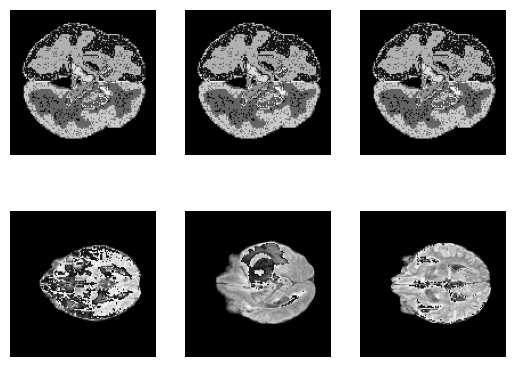

In [ ]:
from matplotlib import pyplot

# Assuming src_images is a 4D array: (num_samples, height, width, num_slices)
n_samples = 3

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(100*data[0][i, :, :, 50,:].astype('uint8'))  # Assuming grayscale images

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(data[1][i, :, :, i + 50,:].astype('uint8'))  # Assuming grayscale images

pyplot.show()


Defining Generator model

In [ ]:

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv3D(n_filters, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder blockn

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    # Upsampling using bicubic interpolation
    upsampled = Conv3DTranspose(n_filters, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # Batch normalization
    normalized = BatchNormalization()(upsampled, training=True)

    # Conditionally add dropout
    if dropout:
        normalized = Dropout(0.5)(normalized, training=True)

    # Merge with skip connection
    merged = Concatenate()([normalized, skip_in])

    # ReLU activation
    activated = Activation('relu')(merged)

    return activated






In [ ]:
# define the standalone generator model
def define_generator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # image input
 in_image = Input((image_shape, image_shape, image_shape, 3))
 # encoder model
 e1 = define_encoder_block(in_image, 32, batchnorm=False)
 e2 = define_encoder_block(e1, 64)
 e3 = define_encoder_block(e2, 128)
 e4 = define_encoder_block(e3, 256)
 e5 = define_encoder_block(e4, 256)
 # bottleneck, no batch norm and relu
 b = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(e5)
 b = Activation('relu')(b)
 # decoder model
 d3 = decoder_block(b, e5, 256)
 d4 = decoder_block(d3, e4, 256)
 d5 = decoder_block(d4, e3, 128)
 d6 = decoder_block(d5, e2, 64, dropout=False)
 d7 = decoder_block(d6, e1, 32, dropout=False)
 # output
 g = Conv3DTranspose(3, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
 # define model
 model = Model(in_image, out_image)
 return model

#input_shape = (91, 109, 91, 3)
#opt = Adam(lr=0.0002, beta_1=0.5)
#model = define_generator(input_shape)
#model.output_shape


In [ ]:
#generate_real_samples function is to generate data samples for models

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, patch_shape, 1))
	return [X1, X2], y

denormalize_data function is to scaled up the image form -1 to 1 to a requried range

In [ ]:
def denormalize_data(data,max_value, min_value):
	X2 = data
	X2o = (X2 + 1)*(max_value - min_value)/2 + min_value
	return X2o

summarized function used for genrating the samples and do a nice visualisation of required image with respect to real images and save the model

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
 # select a sample of input images
 [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 # generate a batch of fake samples
 X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 # scale all pixels from [-1,1] to [0,21]
 X_realA1 = denormalize_data(X_realA,21,0)
 X_realB1 = denormalize_data(X_realB,data[1][0].max(),0)
 X_fakeB1 = denormalize_data(X_fakeB,21,0)
  # plot real source images
 for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(24*X_realA1[i, :, :, 50].astype('uint8'))
 # plot generated target image
 for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + n_samples + i)
  pyplot.axis('off')
  pyplot.imshow(50*X_fakeB1[i, :, :, 50].astype('uint8'))
 # plot real target image
 for i in range(n_samples):
  pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
  pyplot.axis('off')
  pyplot.imshow(24*X_realB1[i, :, :, 50].astype('uint8'))
 # save plot to file
 filename1 = 'plot_%06d.png' % (step+1)
 pyplot.savefig(filename1)
 pyplot.show()
 pyplot.close()
 # save the generator model
 filename2 = 'model_%06d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input((image_shape,image_shape,image_shape,3))
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = filename
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = ((X1 - X1.min()) / (X1.max() - X1.min())) * 2 - 1
	X2 = ((X2 - X2.min()) / (X2.max() - X2.min())) * 2 - 1
	return [X1, X2]

# select a batch of random samples, returns images and target





# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape,patch_shape, 1))
 return X, y

# generate samples and save as a plot and save the model

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

		if (i+1) % (bat_per_epo /10) == 0:
			summarize_performance(i, g_model, dataset)
# load image data




Load the images and resided using load_real_samples

In [ ]:
data2 = load_real_samples(data)
#for i in range(len(data2)):
  #data2[i] = np.repeat(data2[i][:, :, :, :, np.newaxis], 3, axis=4)
#print('Loaded', data2[0].shape, data2[1].shape)

image_shape = data2[0].shape[1]
print(image_shape)
print(data[0].shape[0])


128
100


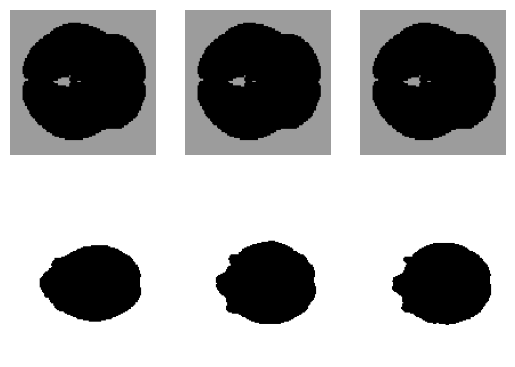

In [ ]:
from matplotlib import pyplot

# Assuming src_images is a 4D array: (num_samples, height, width, num_slices)
n_samples = 3

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(100*data2[0][i, :, :, 50,:].astype('uint8'))  # Assuming grayscale images

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(data2[1][i, :, :, 50,:].astype('uint8'))  # Assuming grayscale images

pyplot.show()


Define and load the images to the model and train

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step
>1, d1[0.447] d2[3.458] g[97.361]
1/1 [==============================] - 0s 376ms/step
>2, d1[0.972] d2[1.478] g[82.858]
1/1 [==============================] - 0s 394ms/step
>3, d1[0.398] d2[0.690] g[68.150]
1/1 [==============================] - 0s 386ms/step
>4, d1[0.544] d2[0.588] g[47.324]
1/1 [==============================] - 0s 377ms/step
>5, d1[0.488] d2[0.529] g[32.730]
1/1 [==============================] - 0s 369ms/step
>6, d1[0.524] d2[0.523] g[19.843]
1/1 [==============================] - 0s 387ms/step
>7, d1[0.497] d2[0.511] g[11.669]
1/1 [==============================] - 0s 389ms/step
>8, d1[0.480] d2[0.488] g[9.276]
1/1 [==============================] - 0s 382ms/step
>9, d1[0.471] d2[0.469] g[7.196]
1/1 [==============================] - 0s 388ms/step
>10, d1[0.456] d2[0.486] g[6.162]
1/1 [==============================] - 4s 4s/step


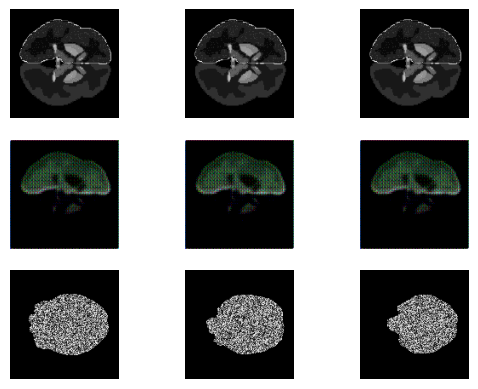

>Saved: plot_000010.png and model_000010.h5
1/1 [==============================] - 0s 399ms/step
>11, d1[0.502] d2[0.501] g[4.992]
1/1 [==============================] - 0s 390ms/step
>12, d1[0.483] d2[0.450] g[5.028]
1/1 [==============================] - 0s 357ms/step
>13, d1[0.433] d2[0.403] g[4.446]
1/1 [==============================] - 0s 387ms/step
>14, d1[0.359] d2[0.352] g[4.542]
1/1 [==============================] - 0s 377ms/step
>15, d1[0.270] d2[0.371] g[5.321]
1/1 [==============================] - 0s 391ms/step
>16, d1[0.354] d2[0.225] g[11.348]
1/1 [==============================] - 0s 392ms/step
>17, d1[0.562] d2[0.799] g[6.916]
1/1 [==============================] - 0s 376ms/step
>18, d1[0.296] d2[0.461] g[5.892]
1/1 [==============================] - 0s 398ms/step
>19, d1[0.379] d2[0.229] g[6.082]
1/1 [==============================] - 0s 379ms/step
>20, d1[0.228] d2[0.211] g[5.548]
1/1 [==============================] - 4s 4s/step


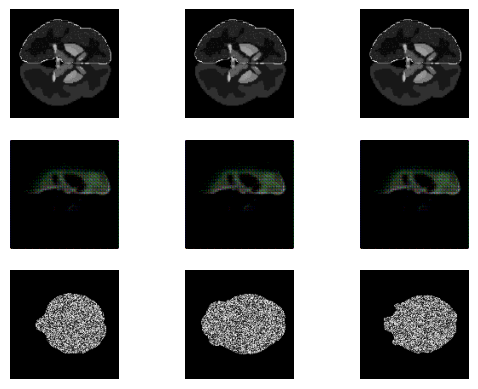

>Saved: plot_000020.png and model_000020.h5
1/1 [==============================] - 0s 401ms/step
>21, d1[0.160] d2[0.123] g[6.652]
1/1 [==============================] - 0s 384ms/step
>22, d1[0.267] d2[0.303] g[5.056]
1/1 [==============================] - 0s 378ms/step
>23, d1[0.097] d2[0.188] g[7.043]
1/1 [==============================] - 0s 392ms/step
>24, d1[0.112] d2[0.048] g[7.430]
1/1 [==============================] - 0s 369ms/step
>25, d1[0.106] d2[0.043] g[7.547]
1/1 [==============================] - 0s 379ms/step
>26, d1[0.101] d2[0.041] g[6.338]
1/1 [==============================] - 0s 377ms/step
>27, d1[0.049] d2[0.039] g[6.299]
1/1 [==============================] - 0s 394ms/step
>28, d1[0.033] d2[0.030] g[6.713]
1/1 [==============================] - 0s 379ms/step
>29, d1[0.023] d2[0.022] g[7.158]
1/1 [==============================] - 0s 374ms/step
>30, d1[0.025] d2[0.018] g[7.199]
1/1 [==============================] - 4s 4s/step


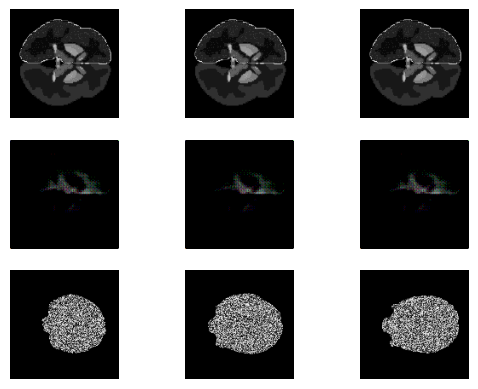

>Saved: plot_000030.png and model_000030.h5
1/1 [==============================] - 0s 380ms/step
>31, d1[0.038] d2[0.019] g[9.211]
1/1 [==============================] - 0s 382ms/step


KeyboardInterrupt: ignored

In [ ]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, data2)

In [ ]:
from matplotlib import pyplot

# Assuming src_images is a 4D array: (num_samples, height, width, num_slices)
n_samples = 3

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[1, :, :, i+74].astype('uint8'))  # Assuming grayscale images

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[1, :, :, i + 50].astype('uint8'))  # Assuming grayscale images

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[1, :, :, i + 50].astype('uint8'))  # Assuming grayscale images

pyplot.show()

trilinear_interpolation_3d used to upsample the images and i was thought to use it the place of Conv3Transposed

In [ ]:
import numpy as np
import math

def trilinear_interpolation_3d(original_img):
    # Get dimensions of the original image
    batch_size, old_h, old_w, old_l, c = original_img.shape

    # Create an array of the desired shape.
    # We will fill in the values later.
    new_h, new_w, new_l = old_h * 2, old_w * 2, old_l * 2
    resized = np.zeros((batch_size, new_h, new_w, new_l, c), dtype=np.uint8)

    # Calculate scaling factors
    h_scale_factor = 2
    w_scale_factor = 2
    l_scale_factor = 2

    for b in range(batch_size):
        for i in range(new_h):
            for j in range(new_w):
                for k in range(new_l):
                    x = i / h_scale_factor
                    y = j / w_scale_factor
                    z = k / l_scale_factor

                    x_floor = math.floor(x)
                    x_ceil = min(old_h - 1, math.ceil(x))
                    y_floor = math.floor(y)
                    y_ceil = min(old_w - 1, math.ceil(y))
                    z_floor = math.floor(z)
                    z_ceil = min(old_l - 1, math.ceil(z))

                    q = None

                    if (x_ceil == x_floor) and (y_ceil == y_floor) and (z_ceil == z_floor):
                        q = original_img[b, int(x), int(y), int(z), :]
                    else:
                        q_values = []
                        for x_idx in [x_floor, x_ceil]:
                            for y_idx in [y_floor, y_ceil]:
                                for z_idx in [z_floor, z_ceil]:
                                    v = original_img[b, x_idx, y_idx, z_idx, :]
                                    q_values.append(v * (1 - abs(x - x_idx)) * (1 - abs(y - y_idx)) * (1 - abs(z - z_idx)))

                        q = sum(q_values)

                    resized[b, i, j, k, :] = q

    return resized

# Example usage
original_img = dataset[0]  # Replace with your dataset
resized_img = trilinear_interpolation_3d(original_img)


KeyboardInterrupt: ignored